### Reference

see [Unsupervised outlier detection in multidimensional data](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00469-z)

In [414]:
import logging
import threading
import itertools
import json

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np  
import scipy as sp
import ruptures as rpt

from sklearn import cluster, datasets, mixture
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import covariance
from sklearn.neighbors import (KernelDensity, NearestNeighbors, kneighbors_graph)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn.utils import check_array

import skimage as ski
from skimage import util as skiutil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
register_matplotlib_converters()

### Generating Test Data

Setting up a data set with 1500 samples in four clusters and 30 outliers at the end 

In [5]:
n_samples = 1500
n_outliers = 30
X, y = datasets.make_blobs(n_samples=n_samples, centers=4,
                       cluster_std=0.60, random_state=43)                        
X_append, y_append = datasets.make_blobs(n_samples=n_outliers, centers=1, cluster_std=5,random_state=12)
X = np.vstack([X,X_append])
y_true = np.hstack([y, [1 for _ in y_append]])
X = X[:, ::-1] 


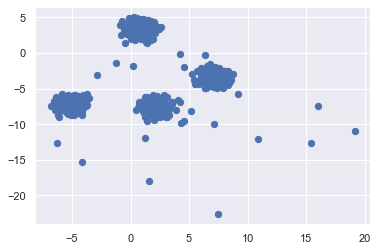

In [6]:
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');

### KMeans 

In [77]:
K=4
# select 4 centers 
rng = np.random.default_rng()
center_index = rng.choice(X.shape[0], size=K, replace=False)

Labels = np.zeros((X.shape[0], K))


#fig,ax = plt.subplots(4,1,figsize=(10, 20))

for cnt in range(20):
    # assign elements to clusters
    labels = np.zeros_like(X[:, 0]).astype(int)
    dists = np.zeros_like(X[:, 0])

    centers_ = []

    for j in range(K):
        centers_.append(X[center_index[j]])
    centers = np.array(centers_)


    for i in range(X.shape[0]):
        dist_to_center = np.linalg.norm(centers - X[i], axis=1)
        labels[i] = np.argmin(dist_to_center)
        
    #if cnt % 4 == 0:    
    #   Labels[:,cnt%4] = labels.copy()
        
    #ax[cnt].scatter(X[:, 0], X[:, 1], c=Labels[:,cnt%4], cmap='viridis');
    
    #input("Press Enter to continue...")
    
    # select new centroids - M step

    
    center_index_ = []
    # cluster by cluster
    for i in range(K):
        
        elements_ = []
        index_ = []
        for j in range(X.shape[0]):
            if labels[j] == i: 
                elements_.append(X[j])
                index_.append(j)
        elements = np.array(elements_)
        index = np.array(index_)
        
        dist_to_center_ = []
        for j in range(elements.shape[0]):
            dist_to_center_.append(np.linalg.norm(elements - elements[j]))
        dist_to_center = np.array(dist_to_center_)
        center_index_.append(index[np.argmin(dist_to_center)])
    
    center_index = np.array(center_index_)
        
        

In [78]:
labels

array([1, 0, 2, ..., 2, 2, 2])

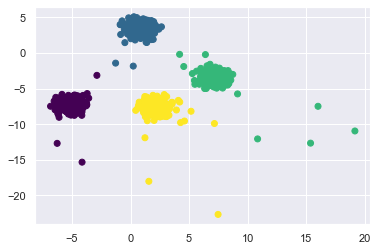

In [79]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');

In [8]:
centers

array([1053,  871,  135,  424])

### Project to 1-dim

Actually this is very close to KNN density estimation with

$$
    localDensity = \frac{k}{N} \frac{1}{Volume \ of d_{k} Sphere}
$$

In [5]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(X)

In [6]:
k = 7
dist, indices = nbrs.kneighbors(X)

In [7]:
# find distance to k-th nearest neighbor
k_distances = np.array([dist[i][k - 1] for i in range(len(dist))])

In [15]:
k_distances.shape

(1530,)

In [8]:
df = pd.DataFrame(X, columns=['X','Y'])

In [9]:
df['d_k'] = k_distances

<AxesSubplot:ylabel='Density'>

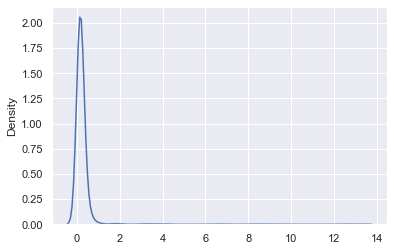

In [10]:
sns.kdeplot(k_distances)

### Boxplots

In [11]:
Q1, Q2 = np.percentile(k_distances, 0), np.percentile(k_distances, 25)
Q3, Q4 = np.percentile(k_distances, 50), np.percentile(k_distances, 75)
Q1, Q2, Q3, Q4

(0.05577668301628839,
 0.11762088514595992,
 0.1513682288905836,
 0.22448413527095057)

In [12]:
c1 = c2 = 1.5

LE = Q1 - c1 * (Q2 - Q1)
UE = Q3 + c2 * (Q3 - Q2)

### Apply a convolution like scheme

#### Schema 2

Use a Gaussian like kernel (N = dimension)

$$
    f_i(x) = \frac{\zeta_i^N}{\pi} \exp^{- \frac{(x-x_i)^2}{\zeta^N}}
$$
    
    and sort of a variable bandwidth estimator
    using the KNN results as local density approximation
    
$$       
    \zeta_i = \frac{\gamma}{(1 + d_i)^N}
$$
    Then define
$$
    Z(x) = \sum_i f_i(x)  \approx \int_{I} f_i(x) dI
$$
    and use a normalizer
$$
    T = \alpha \max_{i}(Z(x_i))
$$

For a reference the following wikipedia article about [Variable KDE](https://en.wikipedia.org/wiki/Variable_kernel_density_estimation) is a good starting point, but it doesn't cover the usage of KNN approximation to the local density as input for ballooning.

In [80]:
# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance 
    #zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(X, mean=X[idx,:].reshape(-1,), cov=zeta_i)
    # much cheaper
    zett += zeta_i**4 * sp.stats.norm.pdf(np.linalg.norm(X - X[idx,:], 2, axis=1), loc=0.0, scale=zeta_i)
zeta = np.array(zeta_)

T = alpha * max(zett)

In [81]:
T

5.9509281202446935

In [74]:
#X[idx,:].reshape(2,-1).shape, X.reshape(2,-1).shape
np.linalg.norm(X - X[idx,:], 2, axis=1)

array([ 0.        , 10.00056739,  8.95007105, ...,  7.7063761 ,
        6.03216725, 17.93495886])

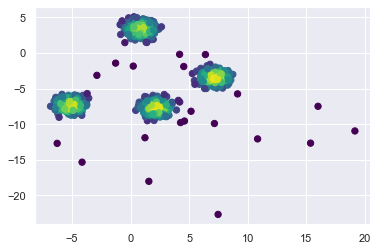

In [82]:
plt.scatter(X[:, 0], X[:, 1], c=zett, s=40, cmap='viridis')

Text(0.5, 1.0, 'Show the outliers')

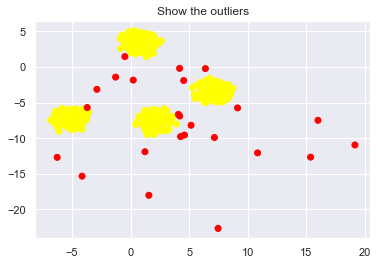

In [83]:
plt.scatter(X[:, 0], X[:, 1], c=(zett > T), cmap='autumn')
plt.title('Show the outliers')

### Simple brute force

In [30]:
gmm_model = Pipeline([('scale', MinMaxScaler()),
                      ('gmm', BayesianGaussianMixture(n_components=1, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')) ])


In [31]:
gmm_model.fit(df['d_k'].values.reshape(-1,1))

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True


Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_init=5,
                                         verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])

In [32]:
predictions = gmm_model.score_samples(df['d_k'].values.reshape(-1,1))
df['d_pred'] = -predictions

In [33]:
# We know the outliers are at the end of the array

In [34]:
-predictions[1501:1530]

array([-1.98397402e+00,  1.64390371e+02,  6.74887418e+01,  3.74872110e+01,
        1.06560771e+01,  4.89504157e+00,  9.37518890e+00,  5.48186503e-01,
       -2.71612986e-01, -1.40747905e+00, -1.99807388e+00, -1.89352246e+00,
       -1.21000465e+00,  1.48428934e+02, -1.99760048e+00,  1.32654429e+00,
        1.33734056e+01,  6.38288776e+00,  6.92326389e+00, -1.25735050e+00,
       -1.75450170e+00,  1.31871917e+01,  2.42714110e-02,  1.57309073e-01,
       -1.67633467e+00,  6.10872630e+01, -1.98155429e+00,  6.74271569e-01,
        4.12859491e+01])

<AxesSubplot:>

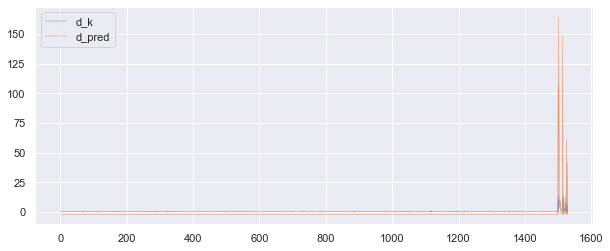

In [35]:
df[['d_k','d_pred']].plot(figsize=(10,4),lw=0.4)

Text(0.5, 1.0, 'Show the outliers')

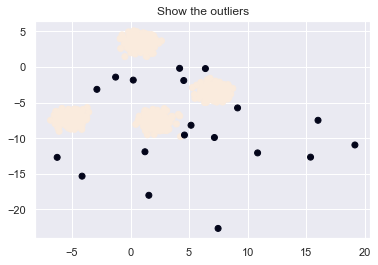

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=(-predictions<0))
plt.title('Show the outliers')

### 

In [80]:
Temperature = 'temperature'

# Get stuff in
df_i = pd.read_csv('./data/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i[Temperature]=df_i['value']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

value  temperature
entity timestamp                              
MyRoom 2017-10-09 20:32:00    3.0          3.0
       2017-10-09 20:33:00    3.0          3.0

<AxesSubplot:xlabel='timestamp'>

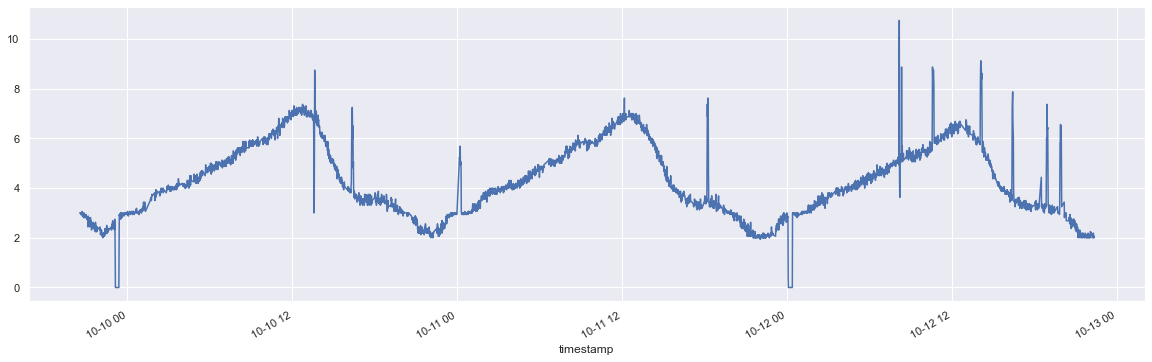

In [99]:
df_i.loc['MyRoom'][Temperature].plot(figsize=(20,6))

<AxesSubplot:xlabel='timestamp'>

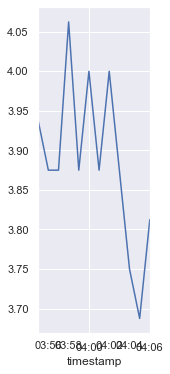

In [409]:
temperature = df_i['value'].values
# 3253:3265 high
# 2803:2815 low
df_i.loc['MyRoom'][3003:3015][Temperature].plot(figsize=(2,6))


In [392]:
temp_fft, xf

(array([67.6875    , -4.36810797, -5.72307621,  0.125     ,  8.76850721,
         3.625     , -7.5625    , -3.75      ,  3.57235479,  2.99310797,
        -0.52692379, -1.9375    ]),
 array([ 0.,  1.,  2.,  3.,  4.,  5., -6., -5., -4., -3., -2., -1.]))

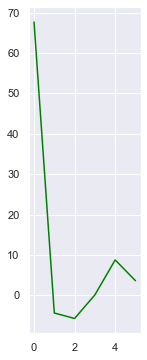

In [411]:
temp_fft = sp.fftpack.rfft(temperature[3253:3265])

xf = sp.fft.fftfreq(12,1/12)[0:6]
plt.figure(figsize=(2,6))

plt.plot(xf, temp_fft[0:6], c='green')
#plt.plot(range(12), temp_fft)

In [382]:
temp_fft

array([67.6875    -0.j        , -4.36810797-5.72307621j,
        0.125     +8.76850721j,  3.625     -7.5625j    ,
       -3.75      +3.57235479j,  2.99310797-0.52692379j,
       -1.9375    -0.j        ,  2.99310797+0.52692379j,
       -3.75      -3.57235479j,  3.625     +7.5625j    ,
        0.125     -8.76850721j, -4.36810797+5.72307621j])

In [164]:
# data is evenly spaced, no need to resample - just extract

temperature = df_i['value'].values
#temp_win = skiutil.view_as_windows(temperature, window_shape=(12,), step=1)
#temp_win_fft = sp.fft.fft(temp_win)

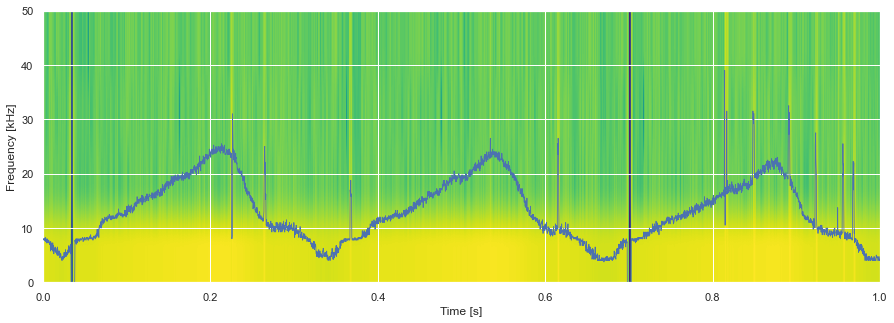

In [255]:
M=12
slices = skiutil.view_as_windows(temperature, window_shape=(M,))
small = 10**(-8)

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
spectrum[spectrum < small] = small
max_spec = np.max(spectrum)

fig, ax = plt.subplots(1, 1, figsize=(15,5), squeeze=False)
S = 20 * np.log10(spectrum / max_spec)
ax[0,0].imshow(S, origin='lower', cmap='viridis', extent=(0, 1, 0, 100 / 2))
ax[0,0].axis('tight')
ax[0,0].set_ylabel('Frequency [kHz]')
ax[0,0].set_xlabel('Time [s]')

ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/4000, temperature*4-4, lw=0.8, zorder=10)


In [473]:
temp_win_fft[0]

array([ 3.58125000e+01-0.j        ,  1.31129763e-01-0.08537659j,
        6.25000000e-02+0.j        ,  6.25000000e-02+0.125j     ,
       -6.93889390e-18+0.10825318j, -1.93629763e-01+0.02287659j,
        6.25000000e-02-0.j        , -1.93629763e-01-0.02287659j,
       -6.93889390e-18-0.10825318j,  6.25000000e-02-0.125j     ,
        6.25000000e-02-0.j        ,  1.31129763e-01+0.08537659j])

In [475]:
temp_win = skiutil.view_as_windows(temperature, window_shape=(2,), step=1)


In [476]:
temp_win.shape

(3999, 2)

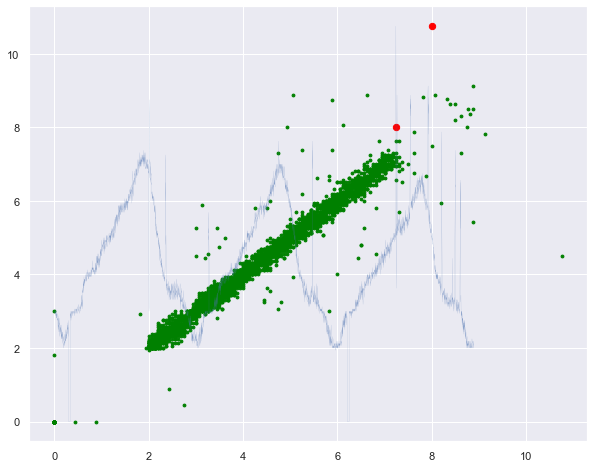

In [504]:

fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=8, c='green', cmap='viridis')
#ax[0,0].axis('tight')
#ax[0,0].set_ylabel('Frequency [kHz]')
#ax[0,0].set_xlabel('Time [s]')

ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)
ax[0,0].scatter(temp_win[3257, 0], temp_win[3257, 1], s=40, c='red')
ax[0,0].scatter(3257/450, temperature[3257], s=40, c='red')

In [613]:
cov_e = covariance.EllipticEnvelope(support_fraction=1.0, random_state=42).fit(temp_win)
cov_m = covariance.EllipticEnvelope(random_state=42).fit(temp_win)


In [648]:
n = cov_m.score_samples(temp_win)

array([2173.70119241, 2173.70119241, 2173.70119241, ..., 2176.09446747,
       2175.38322151, 2175.54294329])

In [677]:
#np.argmax(temp_win[:, 1])
n[3257]

-432.3735549953191

In [705]:
n2 = np.log(-n*4)
max(n2)

9.070460589119945

/tmp/ipykernel_1051965/2137024652.py:17: UserWarning: The following kwargs were not used by contour: 's', 'c'
  ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')


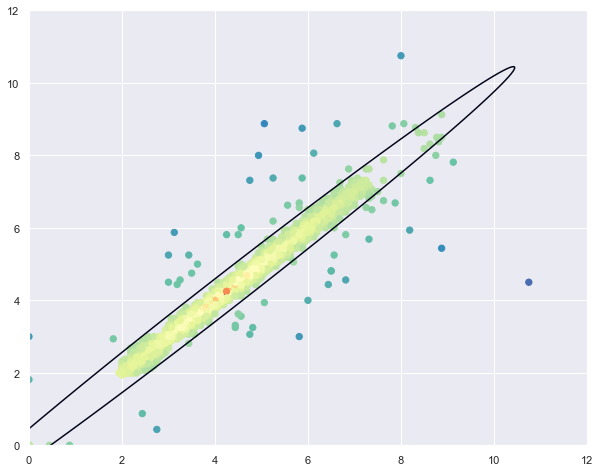

In [710]:
xx1, yy1 = np.meshgrid(np.linspace(0, 12, 500), np.linspace(0, 12, 500))
#Ze = cov_e.decision_function(np.c_[xx1.ravel(), yy1.ravel()]).reshape(xx1.shape)
Zm = cov_m.decision_function(np.c_[xx1.ravel(), yy1.ravel()]).reshape(xx1.shape)


fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=n2, cmap='Spectral', vmin=min(n2), vmax=max(n2)+1)
#ax[0,0].axis('tight')
#ax[0,0].set_ylabel('Frequency [kHz]')
#ax[0,0].set_xlabel('Time [s]')

#ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)
#ax[0,0].scatter(temp_win[3257, 0], temp_win[3257, 1], s=80, c='green')
#ax[0,0].contour(xx1, yy1, -Ze, s=2, levels=[14.0], c='red')

ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')

#ax[0,0].scatter(3257/450, temperature[3257], s=80, c='lightgreen')

In [752]:
distance_ = []
profile_ = []
excl = 4
for i in range(temp_win.shape[0]):
    d = np.linalg.norm(temp_win - temp_win[i], axis=1)
    d[max(i-excl,0):min(i+excl,temp_win.shape[0])] = 10**6
    distance_.append(np.min(d))
    profile_.append(abs(np.argmin(d)-i))

matrix_distance = np.array(distance_)
matrix_profile = np.array(profile_)

In [760]:
temp_win[136], matrix_distance[136], matrix_profile[136]
temp_win[3136], matrix_distance[3136], matrix_profile[3136]

(array([4.5   , 4.4375]), 0.0, 22)

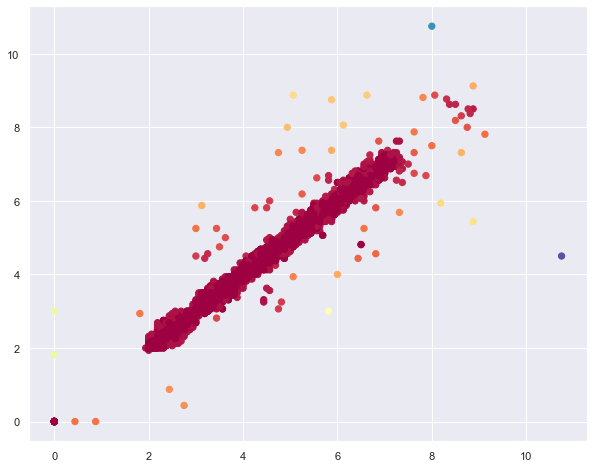

In [764]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=matrix_distance, cmap='Spectral') #, vmin=min(n2), vmax=max(n2)+1)
#ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')
#ax[1,0].plot(range(temp_win.shape[0]), matrix_profile)

In [767]:
temp_win12 = skiutil.view_as_windows(temperature, window_shape=(12,), step=6)


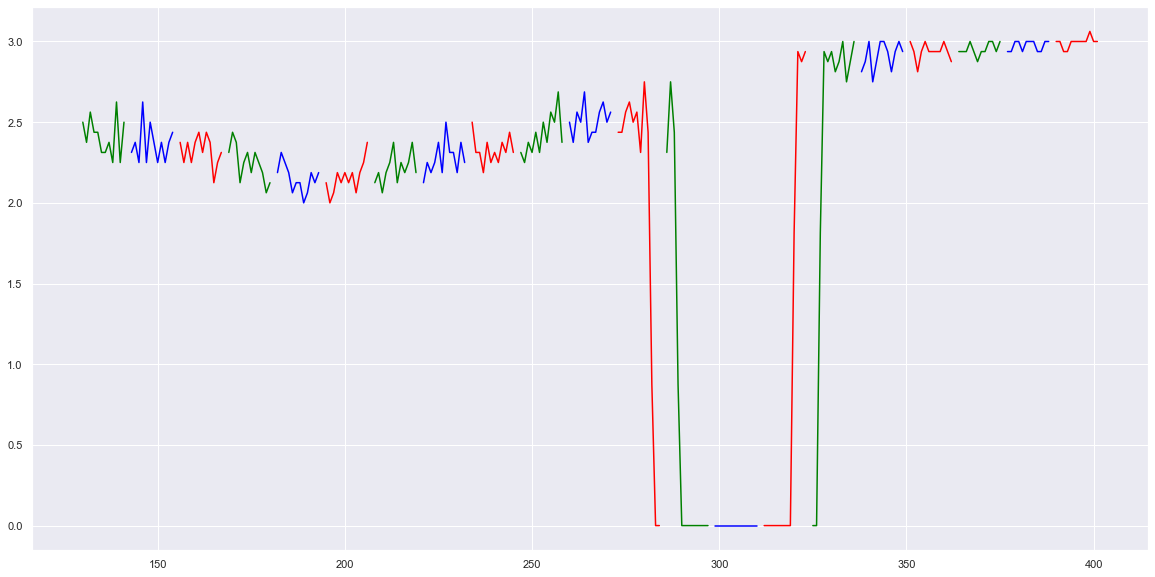

In [805]:
colors = ['red','green','blue']

fig, ax = plt.subplots(1,1,figsize=(20,10))

for i in range(10, temp_win12.shape[0]):
    #color = plt.cm.hsv(i/temp_win12.shape[0])
    color = plt.cm.hsv(i)
    ax.plot(range(i*13,i*13+12), temp_win12[i,:], c=colors[i%3])
    if i>29:    break

In [94]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(temp_win)
k = 7
dist, indices = nbrs.kneighbors(temp_win)
# find distance to k-th nearest neighbor
k_distances = np.array([dist[i][k - 1] for i in range(len(dist))])

In [95]:
# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance 
    zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(temp_win, mean=temp_win[idx,:].reshape(-1,), cov=zeta_i)
zeta = np.array(zeta_)

T = alpha * max(zett)

ValueError: 'c' argument has 3999 elements, which is inconsistent with 'x' and 'y' with size 3989.

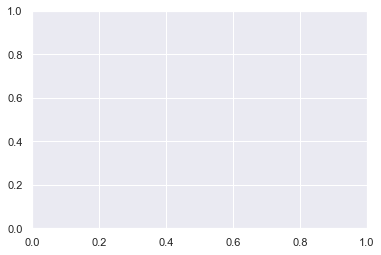

In [472]:
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=zett, s=40, cmap='viridis')

Text(0.5, 1.0, 'Show the outliers (in red)')

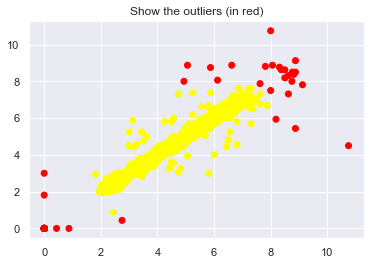

In [97]:
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=(zett > T), cmap='autumn')
plt.title('Show the outliers (in red)')

In [119]:
X = temp_win

### UMAP

In [332]:
X = skiutil.view_as_windows(temperature, window_shape=(12,), step=1)


In [282]:
import umap
import umap.plot

mapper = umap.UMAP(densmap=True, n_neighbors=30).fit(X)

In [306]:
n = np.zeros(3989)
n[3253] = 10

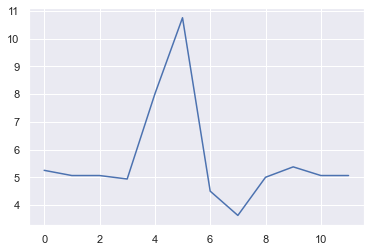

In [301]:
plt.plot(range(12), X[3253])
#df_i.loc['MyRoom'][2803:2815][Temperature].plot(figsize=(2,6))

In [344]:
XX = mapper.transform(X)
kmeans = cluster.KMeans(40).fit(XX)
kmeans

KMeans(n_clusters=40)

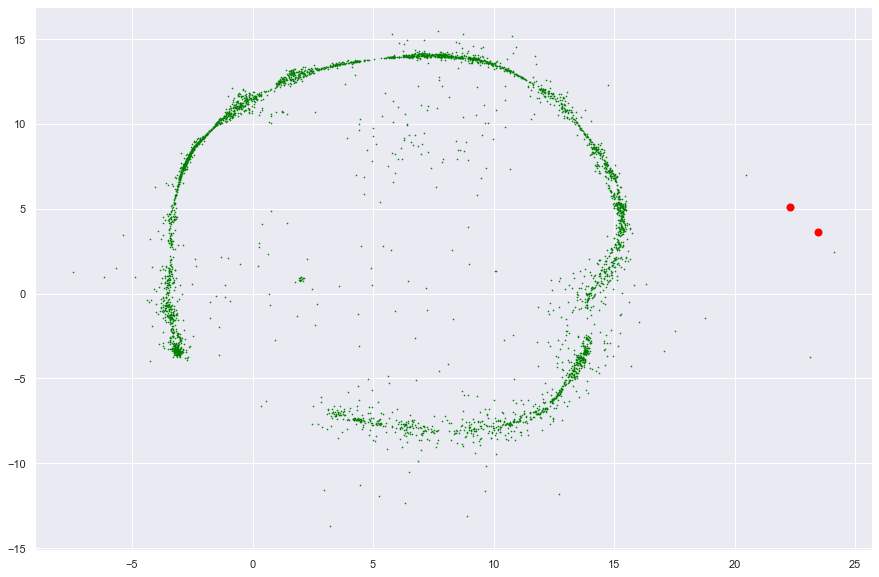

In [339]:
#umap.plot.points(mapper)
fig, ax = plt.subplots(1,1, figsize=(15,10))
#ax.set_xlim()
#ax.scatter(XX[:, 0], XX[:, 1],
#            c=kmeans.predict(XX), s=0.4, lw=1, cmap='Spectral')
ax.scatter(XX[:, 0], XX[:, 1],
            c='green', s=0.4, lw=1, cmap='Spectral')
ax.scatter(mapper.transform(X)[3253:3255, 0], mapper.transform(X)[3253:3255, 1],
            c='red', lw=2, zorder=1)


In [345]:
kmeans.predict(XX[3253:3255]), kmeans

(array([28, 28], dtype=int32), KMeans(n_clusters=40))

In [349]:
XL = kmeans.predict(XX)

<BarContainer object of 40 artists>

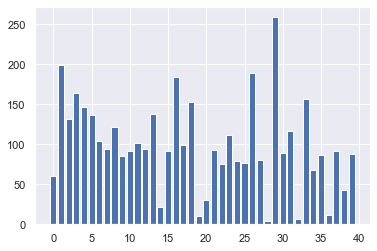

In [362]:
n_ = []
for j in range(40):
    n_.append(XL.shape[0] - np.count_nonzero(XL - j))
n = np.array(n_)
plt.bar(range(n.size),n)

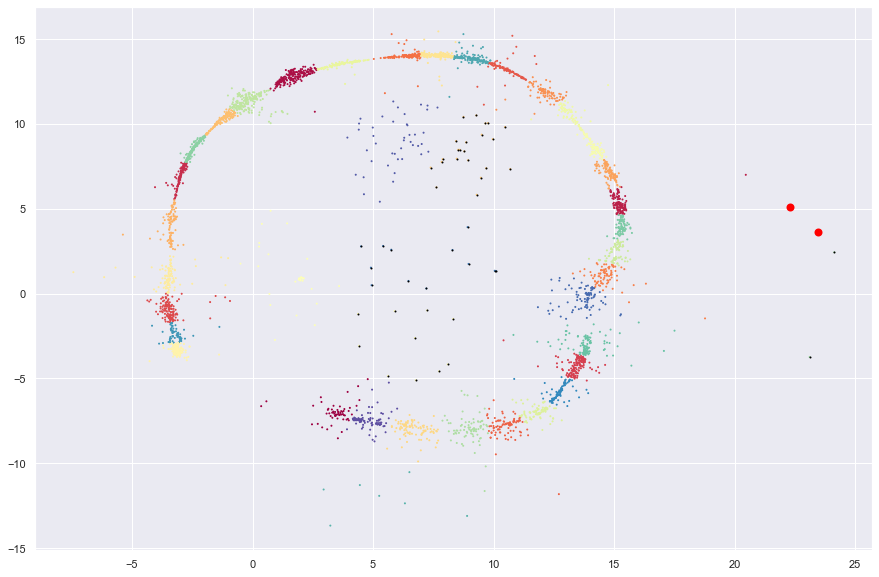

In [368]:
#umap.plot.points(mapper)
fig, ax = plt.subplots(1,1, figsize=(15,10))
#ax.set_xlim()
ax.scatter(XX[:, 0], XX[:, 1],
            c=kmeans.predict(XX), s=1, lw=1, cmap='Spectral')
for i in range(XX.shape[0]):
    if XL[i] == 14 or XL[i] == 19 or XL[i] == 28 or XL[i] == 36:
        ax.scatter(XX[i,0], XX[i,1], s=1, c='black')
ax.scatter(XX[3253:3255, 0], XX[3253:3255, 1],
            c='red', lw=2, zorder=1)

In [448]:
#cov_e = covariance.EllipticEnvelope(random_state=42).fit(X)
cov_mcd = covariance.MinCovDet(random_state=42).fit(X)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [470]:
n = cov_mcd.mahalanobis(X)
n2 = np.where(n > 20, 20, n)

In [423]:
covE = cov_e.predict(X)

In [469]:
n2

array([2.37897795, 3.39844239, 3.87057721, ..., 7.83528975, 7.91784344,
       7.25327156])

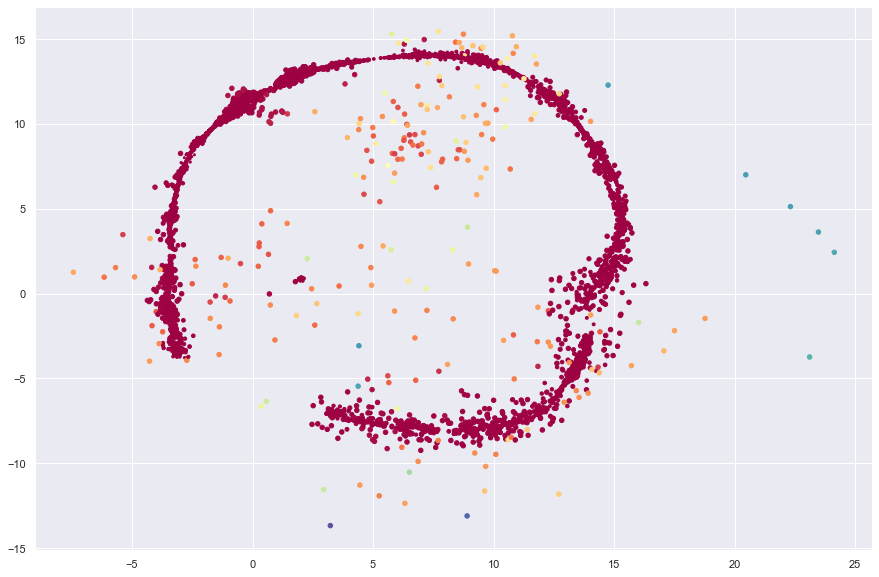

In [471]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
#ax.set_xlim()
ax.scatter(XX[:, 0], XX[:, 1],
            c=cov_mcd.mahalanobis(X), s=n2, cmap='Spectral')
#for i in range(XX.shape[0]):
#    if XL[i] == 14 or XL[i] == 19 or XL[i] == 28 or XL[i] == 36:
#        ax.scatter(XX[i,0], XX[i,1], s=1, c='black')
#ax.scatter(XX[3253:3255, 0], XX[3253:3255, 1],
#            c='blue', lw=2, zorder=1)

### K-Means

In [272]:
K = 12
# select 4 centers 
rng = np.random.default_rng()
center_index = rng.choice(X.shape[0], size=K, replace=False)

Labels = np.zeros((X.shape[0], K))


#fig,ax = plt.subplots(4,1,figsize=(10, 20))

for cnt in range(20):
    # assign elements to clusters
    labels = np.zeros_like(X[:, 0]).astype(int)
    dists = np.zeros_like(X[:, 0])

    centers_ = []

    for j in range(K):
        centers_.append(X[center_index[j]])
    centers = np.array(centers_)

    # assign elements to clusters
    for i in range(X.shape[0]):
        dist_to_center = np.linalg.norm(centers - X[i], axis=1)
        labels[i] = np.argmin(dist_to_center)
        
   
    # select new centroids - M step
    center_index_ = []
    # cluster by cluster
    for i in range(K):
        
        elements_ = []
        index_ = []
        for j in range(X.shape[0]):
            if labels[j] == i: 
                elements_.append(X[j])
                index_.append(j)
        elements = np.array(elements_)
        index = np.array(index_)
        
        dist_to_center_ = []
        for j in range(elements.shape[0]):
            dist_to_center_.append(np.linalg.norm(elements - elements[j]))
        dist_to_center = np.array(dist_to_center_)
        center_index_.append(index[np.argmin(dist_to_center)])
    
    center_index = np.array(center_index_)
        

In [273]:
sizes_ = []
for j in range(K):
    sizes_.append(temp_win.shape[0] - np.count_nonzero(labels - j))
sizes = np.array(sizes_)

In [274]:
centers, sizes

(array([[4.875 , 4.875 , 4.8125, 4.8125, 4.8125, 4.8125, 4.6875, 4.875 ,
         4.9375, 4.875 , 4.9375, 4.875 ],
        [4.5   , 4.5625, 4.375 , 4.5625, 4.4375, 4.125 , 4.25  , 4.25  ,
         4.0625, 4.25  , 4.0625, 4.125 ],
        [5.9375, 5.9375, 5.9375, 6.    , 6.0625, 6.    , 5.9375, 5.875 ,
         5.875 , 5.875 , 5.8125, 5.8125],
        [3.8125, 3.6875, 3.6875, 3.75  , 3.75  , 3.625 , 3.625 , 3.75  ,
         3.6875, 3.8125, 3.8125, 3.75  ],
        [4.375 , 4.375 , 4.5   , 4.5   , 4.625 , 4.5   , 4.3125, 4.5   ,
         4.5625, 4.4375, 4.5   , 4.5625],
        [4.    , 4.0625, 4.125 , 4.0625, 4.    , 4.0625, 4.125 , 4.0625,
         4.0625, 4.0625, 4.125 , 4.3125],
        [3.5   , 3.375 , 3.4375, 3.5625, 3.5   , 3.4375, 3.4375, 3.4375,
         3.4375, 3.5625, 3.4375, 3.5   ],
        [4.    , 3.9375, 3.9375, 3.875 , 3.875 , 3.9375, 3.9375, 3.9375,
         4.    , 3.8125, 3.875 , 3.9375],
        [5.25  , 5.1875, 5.1875, 5.125 , 5.3125, 5.25  , 5.3125, 5.3125,
       